# Skin Lesion Classification — Transfer Learning
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```

**Model:** EfficientNet-B0

In [8]:
# Environment & imports
# Install PyTorch with CUDA support (run this cell first if CUDA is not available)
# Your system has CUDA 12.7, so use cu124 (compatible with CUDA 12.x):
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Alternative for CUDA 12.1:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install other packages
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Force GPU usage
if not torch.cuda.is_available():
    print("CUDA not available. Installing CPU version of PyTorch...")
    # Install CPU version if GPU not available
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    device = torch.device("cpu")
    print("Using CPU. To use GPU, install CUDA and PyTorch with CUDA support.")
else:
    device = torch.device("cuda")
    print("Device:", device)
    print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "N/A")

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Device: cuda
CUDA version: 12.4
Note: you may need to restart the kernel to use updated packages.
Device: cuda
CUDA version: 12.4


In [9]:
# Paths (change these to your dataset locations)
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [10]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [11]:
# EfficientNet-B0 (torchvision if available)
try:
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # If torchvision doesn't have efficientnet in your environment, use timm (uncomment install if needed)
    # !pip install timm -q
    import timm
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)

In [12]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 40  # change as needed


In [13]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=40, model_name="model", early_stopping_patience=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    epochs_no_improve = 0 if early_stopping_patience is not None else None

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
                    if early_stopping_patience is not None:
                        epochs_no_improve = 0
                else:
                    if early_stopping_patience is not None:
                        epochs_no_improve += 1

        if early_stopping_patience is not None and epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if scheduler is not None:
            scheduler.step()
        print("-"*40)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [14]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="EfficientNet-B0")


Epoch 1/40


100%|██████████| 333/333 [01:37<00:00,  3.41it/s]


train Loss: 1.3612 Acc: 0.4984 F1: 0.4668


100%|██████████| 42/42 [00:13<00:00,  3.19it/s]



val Loss: 0.8246 Acc: 0.7046 F1: 0.7196
----------------------------------------
Epoch 2/40


100%|██████████| 333/333 [01:44<00:00,  3.20it/s]


train Loss: 0.7413 Acc: 0.6916 F1: 0.6891


100%|██████████| 42/42 [00:08<00:00,  5.21it/s]



val Loss: 0.5301 Acc: 0.8033 F1: 0.8099
----------------------------------------
Epoch 3/40


100%|██████████| 333/333 [01:48<00:00,  3.07it/s]



train Loss: 0.5764 Acc: 0.7599 F1: 0.7495


100%|██████████| 42/42 [00:08<00:00,  5.21it/s]



val Loss: 0.4084 Acc: 0.8380 F1: 0.8267
----------------------------------------
Epoch 4/40


100%|██████████| 333/333 [01:51<00:00,  2.98it/s]


train Loss: 0.4904 Acc: 0.7917 F1: 0.7801


100%|██████████| 42/42 [00:08<00:00,  5.23it/s]



val Loss: 0.3129 Acc: 0.8855 F1: 0.8812
----------------------------------------
Epoch 5/40


100%|██████████| 333/333 [01:47<00:00,  3.10it/s]


train Loss: 0.4168 Acc: 0.8263 F1: 0.8143


100%|██████████| 42/42 [00:07<00:00,  5.28it/s]



val Loss: 0.2349 Acc: 0.9073 F1: 0.8973
----------------------------------------
Epoch 6/40


100%|██████████| 333/333 [01:30<00:00,  3.67it/s]


train Loss: 0.3837 Acc: 0.8391 F1: 0.8254


100%|██████████| 42/42 [00:07<00:00,  5.50it/s]


val Loss: 0.2211 Acc: 0.9186 F1: 0.8828
----------------------------------------
Epoch 7/40


100%|██████████| 333/333 [01:27<00:00,  3.81it/s]


train Loss: 0.3701 Acc: 0.8510 F1: 0.8367


100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


val Loss: 0.2106 Acc: 0.9194 F1: 0.8937
----------------------------------------
Epoch 8/40


100%|██████████| 333/333 [01:33<00:00,  3.56it/s]


train Loss: 0.3197 Acc: 0.8681 F1: 0.8555


100%|██████████| 42/42 [00:09<00:00,  4.60it/s]



val Loss: 0.2092 Acc: 0.9216 F1: 0.8977
----------------------------------------
Epoch 9/40


100%|██████████| 333/333 [01:34<00:00,  3.54it/s]


train Loss: 0.3227 Acc: 0.8725 F1: 0.8575


100%|██████████| 42/42 [00:07<00:00,  5.45it/s]



val Loss: 0.1306 Acc: 0.9533 F1: 0.9346
----------------------------------------
Epoch 10/40


100%|██████████| 333/333 [01:30<00:00,  3.68it/s]


train Loss: 0.3025 Acc: 0.8794 F1: 0.8665


100%|██████████| 42/42 [00:07<00:00,  5.37it/s]



val Loss: 0.1356 Acc: 0.9563 F1: 0.9429
----------------------------------------
Epoch 11/40


100%|██████████| 333/333 [01:31<00:00,  3.65it/s]


train Loss: 0.2740 Acc: 0.8883 F1: 0.8755


100%|██████████| 42/42 [00:08<00:00,  4.79it/s]



val Loss: 0.1307 Acc: 0.9540 F1: 0.9429
----------------------------------------
Epoch 12/40


100%|██████████| 333/333 [01:30<00:00,  3.67it/s]


train Loss: 0.2665 Acc: 0.8923 F1: 0.8791


100%|██████████| 42/42 [00:07<00:00,  5.31it/s]


val Loss: 0.1434 Acc: 0.9472 F1: 0.9228
----------------------------------------
Epoch 13/40


100%|██████████| 333/333 [01:31<00:00,  3.65it/s]


train Loss: 0.2542 Acc: 0.8979 F1: 0.8849


100%|██████████| 42/42 [00:07<00:00,  5.41it/s]


val Loss: 0.1377 Acc: 0.9488 F1: 0.9316
----------------------------------------
Epoch 14/40


100%|██████████| 333/333 [01:32<00:00,  3.60it/s]


train Loss: 0.2331 Acc: 0.9068 F1: 0.9049


100%|██████████| 42/42 [00:08<00:00,  4.86it/s]


val Loss: 0.1368 Acc: 0.9631 F1: 0.9422
----------------------------------------
Epoch 15/40


100%|██████████| 333/333 [01:29<00:00,  3.72it/s]


train Loss: 0.2065 Acc: 0.9134 F1: 0.9089


100%|██████████| 42/42 [00:07<00:00,  5.35it/s]



val Loss: 0.1222 Acc: 0.9563 F1: 0.9437
----------------------------------------
Epoch 16/40


100%|██████████| 333/333 [01:31<00:00,  3.63it/s]


train Loss: 0.2266 Acc: 0.9120 F1: 0.9057


100%|██████████| 42/42 [00:08<00:00,  4.90it/s]



val Loss: 0.1228 Acc: 0.9646 F1: 0.9498
----------------------------------------
Epoch 17/40


100%|██████████| 333/333 [01:31<00:00,  3.63it/s]


train Loss: 0.2179 Acc: 0.9183 F1: 0.9114


100%|██████████| 42/42 [00:09<00:00,  4.63it/s]



val Loss: 0.0972 Acc: 0.9668 F1: 0.9534
----------------------------------------
Epoch 18/40


100%|██████████| 333/333 [01:31<00:00,  3.64it/s]


train Loss: 0.1997 Acc: 0.9243 F1: 0.9141


100%|██████████| 42/42 [00:07<00:00,  5.36it/s]


val Loss: 0.1134 Acc: 0.9593 F1: 0.9465
----------------------------------------
Epoch 19/40


100%|██████████| 333/333 [01:32<00:00,  3.59it/s]


train Loss: 0.1907 Acc: 0.9236 F1: 0.9184


100%|██████████| 42/42 [00:10<00:00,  3.97it/s]



val Loss: 0.0956 Acc: 0.9676 F1: 0.9544
----------------------------------------
Epoch 20/40


100%|██████████| 333/333 [01:31<00:00,  3.66it/s]



train Loss: 0.1804 Acc: 0.9267 F1: 0.9221


100%|██████████| 42/42 [00:07<00:00,  5.40it/s]



val Loss: 0.0868 Acc: 0.9736 F1: 0.9610
----------------------------------------
Epoch 21/40


100%|██████████| 333/333 [01:33<00:00,  3.57it/s]


train Loss: 0.1831 Acc: 0.9289 F1: 0.9228


100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


val Loss: 0.1035 Acc: 0.9668 F1: 0.9493
----------------------------------------
Epoch 22/40


100%|██████████| 333/333 [01:29<00:00,  3.74it/s]


train Loss: 0.1732 Acc: 0.9310 F1: 0.9226


100%|██████████| 42/42 [00:07<00:00,  5.54it/s]


val Loss: 0.1125 Acc: 0.9714 F1: 0.9591
----------------------------------------
Epoch 23/40


100%|██████████| 333/333 [01:27<00:00,  3.81it/s]


train Loss: 0.1669 Acc: 0.9301 F1: 0.9253


100%|██████████| 42/42 [00:07<00:00,  5.64it/s]


val Loss: 0.1198 Acc: 0.9586 F1: 0.9382
----------------------------------------
Epoch 24/40


100%|██████████| 333/333 [01:30<00:00,  3.69it/s]


train Loss: 0.1641 Acc: 0.9312 F1: 0.9292


100%|██████████| 42/42 [00:08<00:00,  5.10it/s]



val Loss: 0.0896 Acc: 0.9766 F1: 0.9677
----------------------------------------
Epoch 25/40


100%|██████████| 333/333 [01:30<00:00,  3.70it/s]



train Loss: 0.1540 Acc: 0.9378 F1: 0.9344


100%|██████████| 42/42 [00:07<00:00,  5.60it/s]


val Loss: 0.0948 Acc: 0.9699 F1: 0.9512
----------------------------------------
Epoch 26/40


100%|██████████| 333/333 [01:31<00:00,  3.65it/s]


train Loss: 0.1511 Acc: 0.9375 F1: 0.9363


100%|██████████| 42/42 [00:07<00:00,  5.35it/s]


val Loss: 0.0949 Acc: 0.9706 F1: 0.9581
----------------------------------------
Epoch 27/40


100%|██████████| 333/333 [01:26<00:00,  3.85it/s]


train Loss: 0.1498 Acc: 0.9408 F1: 0.9333


100%|██████████| 42/42 [00:07<00:00,  5.51it/s]


val Loss: 0.1183 Acc: 0.9683 F1: 0.9560
----------------------------------------
Epoch 28/40


100%|██████████| 333/333 [01:28<00:00,  3.75it/s]


train Loss: 0.1537 Acc: 0.9412 F1: 0.9334


100%|██████████| 42/42 [00:07<00:00,  5.52it/s]


val Loss: 0.0976 Acc: 0.9661 F1: 0.9400
----------------------------------------
Epoch 29/40


100%|██████████| 333/333 [01:27<00:00,  3.79it/s]


train Loss: 0.1561 Acc: 0.9374 F1: 0.9319


100%|██████████| 42/42 [00:07<00:00,  5.37it/s]


val Loss: 0.0911 Acc: 0.9714 F1: 0.9558
----------------------------------------
Epoch 30/40


100%|██████████| 333/333 [01:28<00:00,  3.77it/s]


train Loss: 0.1466 Acc: 0.9423 F1: 0.9347


100%|██████████| 42/42 [00:07<00:00,  5.38it/s]


val Loss: 0.0801 Acc: 0.9781 F1: 0.9655
----------------------------------------
Epoch 31/40


100%|██████████| 333/333 [01:27<00:00,  3.78it/s]


train Loss: 0.1292 Acc: 0.9473 F1: 0.9450


100%|██████████| 42/42 [00:07<00:00,  5.34it/s]


val Loss: 0.0935 Acc: 0.9714 F1: 0.9584
----------------------------------------
Epoch 32/40


100%|██████████| 333/333 [01:27<00:00,  3.80it/s]


train Loss: 0.1232 Acc: 0.9458 F1: 0.9443


100%|██████████| 42/42 [00:08<00:00,  5.24it/s]



val Loss: 0.0964 Acc: 0.9781 F1: 0.9689
----------------------------------------
Epoch 33/40


100%|██████████| 333/333 [01:27<00:00,  3.79it/s]


train Loss: 0.1280 Acc: 0.9482 F1: 0.9484


100%|██████████| 42/42 [00:07<00:00,  5.37it/s]



val Loss: 0.0840 Acc: 0.9797 F1: 0.9695
----------------------------------------
Epoch 34/40


100%|██████████| 333/333 [01:29<00:00,  3.73it/s]


train Loss: 0.1257 Acc: 0.9494 F1: 0.9450


100%|██████████| 42/42 [00:07<00:00,  5.58it/s]


val Loss: 0.0889 Acc: 0.9729 F1: 0.9535
----------------------------------------
Epoch 35/40


100%|██████████| 333/333 [01:27<00:00,  3.81it/s]


train Loss: 0.1288 Acc: 0.9482 F1: 0.9466


100%|██████████| 42/42 [00:07<00:00,  5.51it/s]


val Loss: 0.0845 Acc: 0.9774 F1: 0.9612
----------------------------------------
Epoch 36/40


100%|██████████| 333/333 [01:32<00:00,  3.60it/s]


train Loss: 0.1359 Acc: 0.9456 F1: 0.9418


100%|██████████| 42/42 [00:08<00:00,  4.85it/s]


val Loss: 0.0832 Acc: 0.9766 F1: 0.9623
----------------------------------------
Epoch 37/40


100%|██████████| 333/333 [01:32<00:00,  3.59it/s]


train Loss: 0.1281 Acc: 0.9466 F1: 0.9416


100%|██████████| 42/42 [00:08<00:00,  4.80it/s]


val Loss: 0.0782 Acc: 0.9744 F1: 0.9592
----------------------------------------
Epoch 38/40


100%|██████████| 333/333 [01:39<00:00,  3.33it/s]


train Loss: 0.1276 Acc: 0.9523 F1: 0.9485


100%|██████████| 42/42 [00:08<00:00,  5.14it/s]


val Loss: 0.1033 Acc: 0.9789 F1: 0.9613
----------------------------------------
Epoch 39/40


100%|██████████| 333/333 [01:33<00:00,  3.56it/s]


train Loss: 0.1211 Acc: 0.9529 F1: 0.9508


100%|██████████| 42/42 [00:08<00:00,  5.21it/s]


val Loss: 0.0897 Acc: 0.9812 F1: 0.9690
----------------------------------------
Epoch 40/40


100%|██████████| 333/333 [01:41<00:00,  3.28it/s]


train Loss: 0.1240 Acc: 0.9509 F1: 0.9446


100%|██████████| 42/42 [00:08<00:00,  5.08it/s]

val Loss: 0.1177 Acc: 0.9721 F1: 0.9545
----------------------------------------
Training complete in 67m 24s
Best val F1: 0.9695


In [15]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


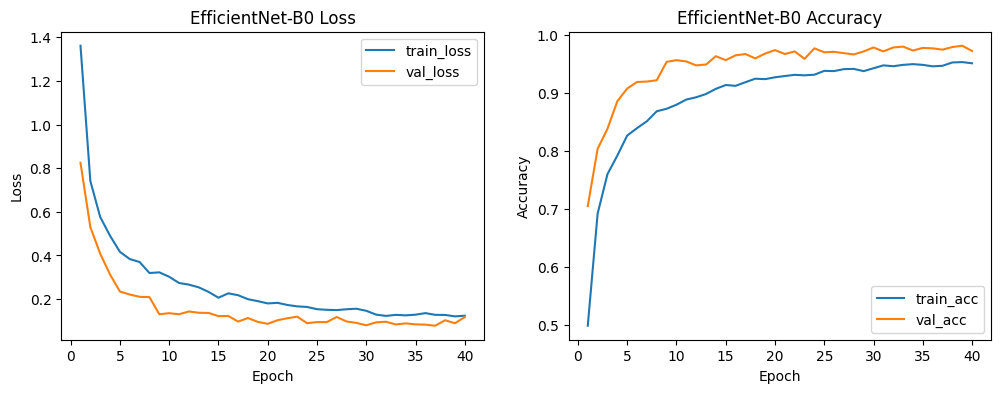

In [16]:
plot_history(history, model_name="EfficientNet-B0")


In [17]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


In [18]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.91      0.90      0.90        86
             Chickenpox       0.96      1.00      0.98       112
                 Cowpox       0.99      1.00      0.99        99
         Dermatofibroma       1.00      0.96      0.98        23
                   HFMD       1.00      1.00      1.00       241
                Healthy       0.98      0.99      0.99       171
                Measles       1.00      0.99      0.99        82
              Monkeypox       1.00      0.98      0.99       426
Squamous cell carcinoma       0.86      0.89      0.87        62
       Vascular lesions       1.00      1.00      1.00        25

               accuracy                           0.98      1327
              macro avg       0.97      0.97      0.97      1327
           weighted avg       0.98      0.98      0.98      1327

Confusion matrix:
 [[ 77   0   0   0   0   0   0   0   9   0]
 [  0 112   0   0   0   0

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 1337
Loaded checkpoint: EfficientNet-B0_best.pth
                         precision    recall  f1-score   support

      Actinic keratoses       0.91      0.90      0.90        88
             Chickenpox       0.96      1.00      0.98       113
                 Cowpox       1.00      0.99      0.99        99
         Dermatofibroma       0.96      0.88      0.92        25
                   HFMD       0.99      1.00      1.00       242
                Healthy       0.99      0.99      0.99       171
                Measles       0.98      1.00      0.99        83
              Monkeypox       1.00      0.98      0.99       426
Squamous cell carcinoma       0.88      0.92      0.90        64
       Vascular lesions       1.00      1.00     

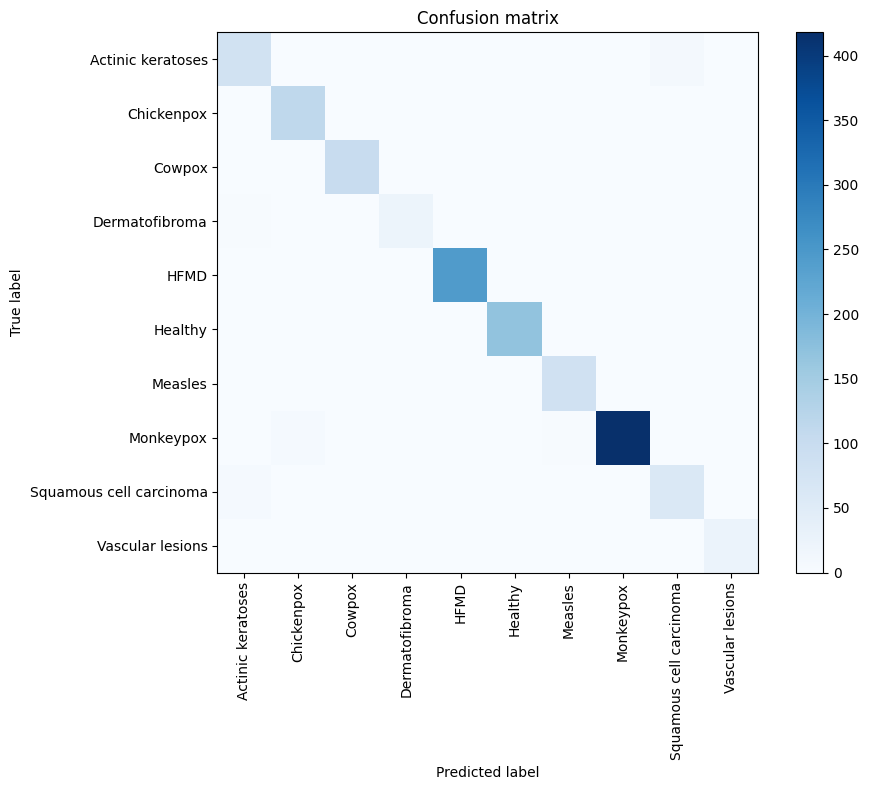

Saved test_predictions.csv


In [19]:

%pip install pandas
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# path to test data 
test_dir = r"D:\archive\test"   

# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# load best checkpoint (if you saved it during training)
ckpt_path = "EfficientNet-B0_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("Loaded checkpoint:", ckpt_path)
except Exception as e:
    print("Checkpoint load failed (using current model):", e)

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# optional: plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=90)
plt.yticks(tick_marks, test_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# optional: save per-image predictions (filenames, true, pred, prob)
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": filenames,
    "true": [test_dataset.classes[i] for i in y_true],
    "pred": [test_dataset.classes[i] for i in y_pred],
    "prob_top": [round(float(np.max(p)),4) for p in probs]
})
df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")

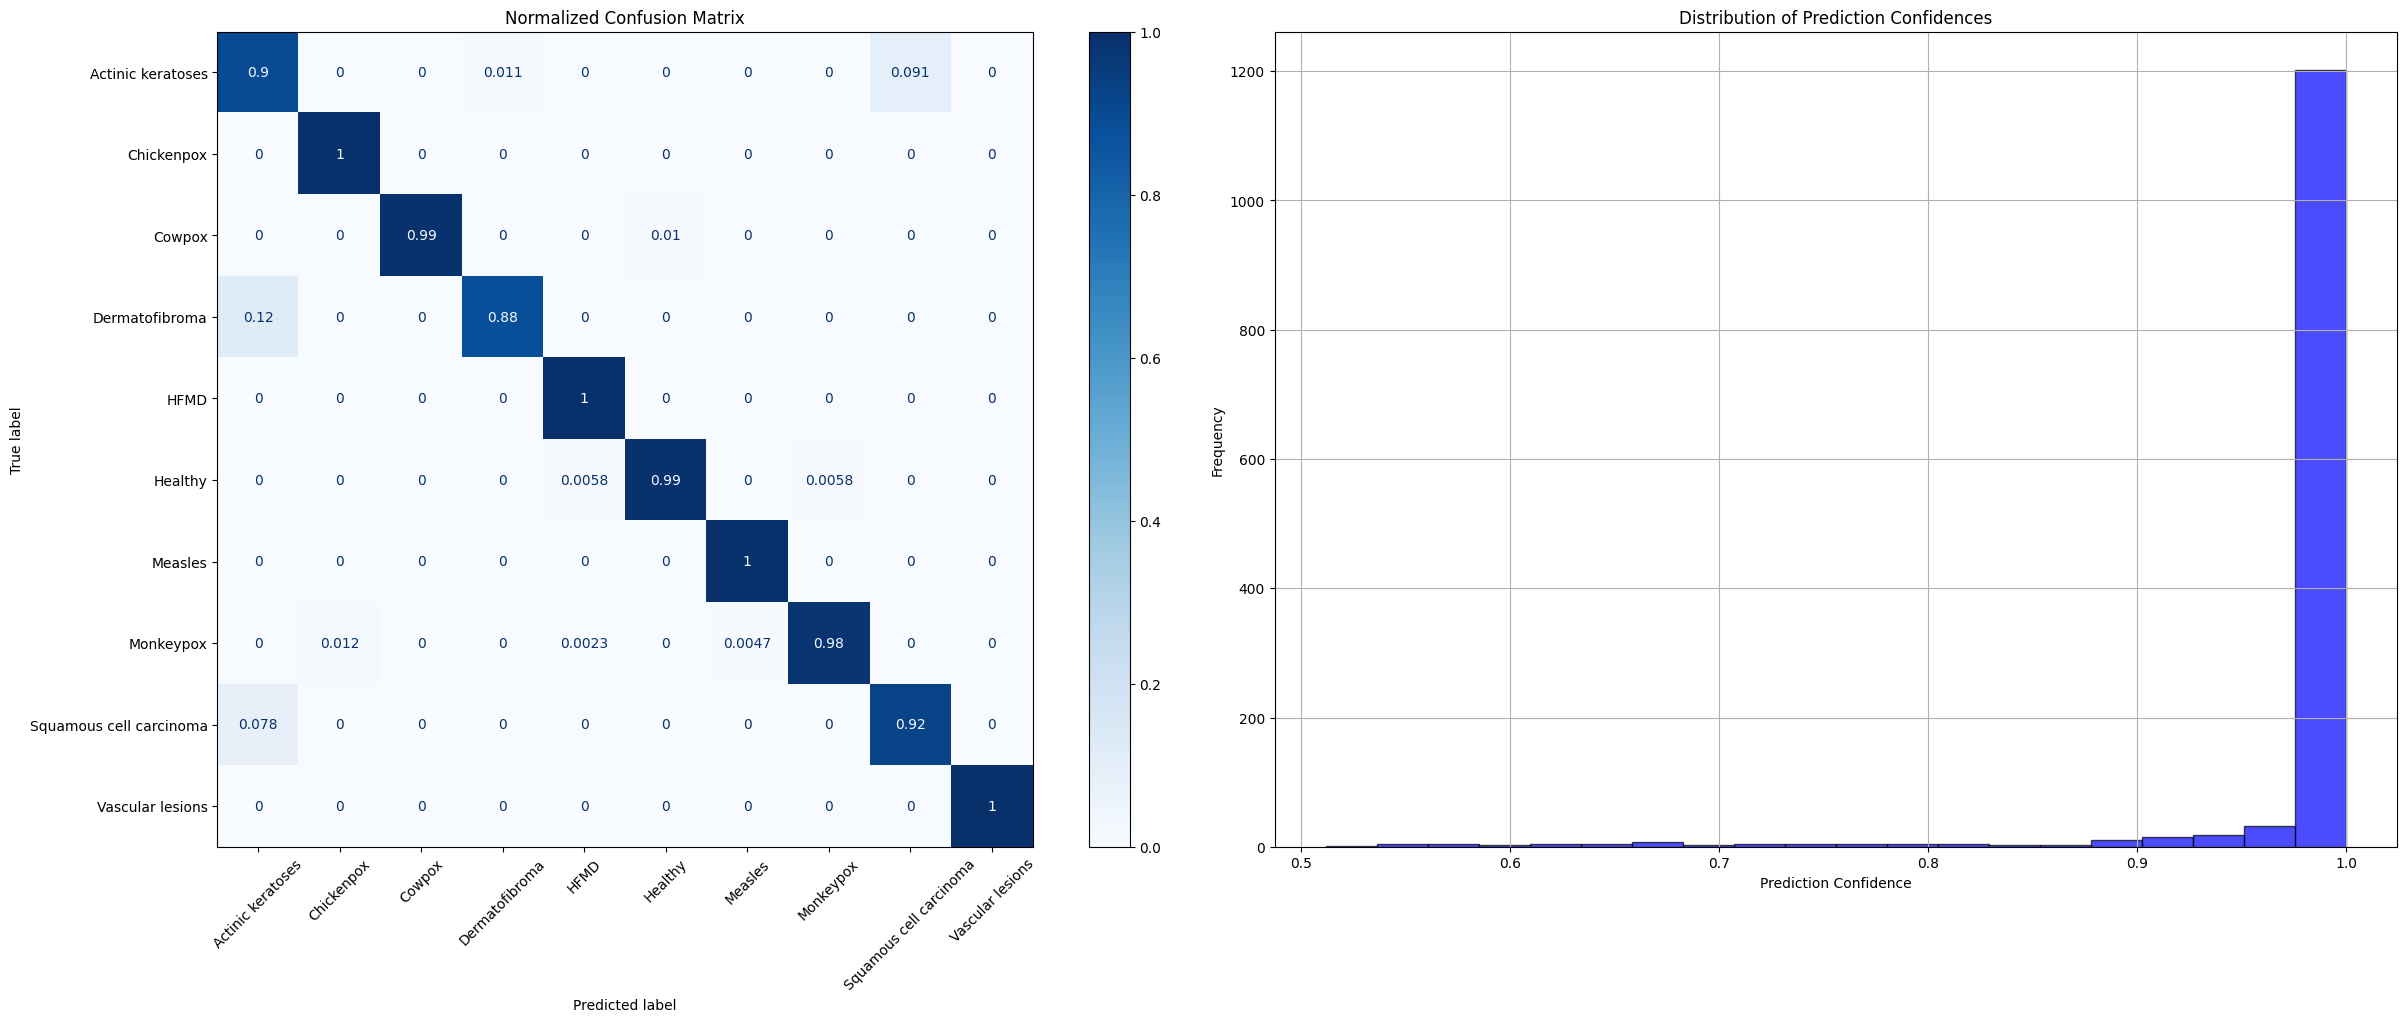

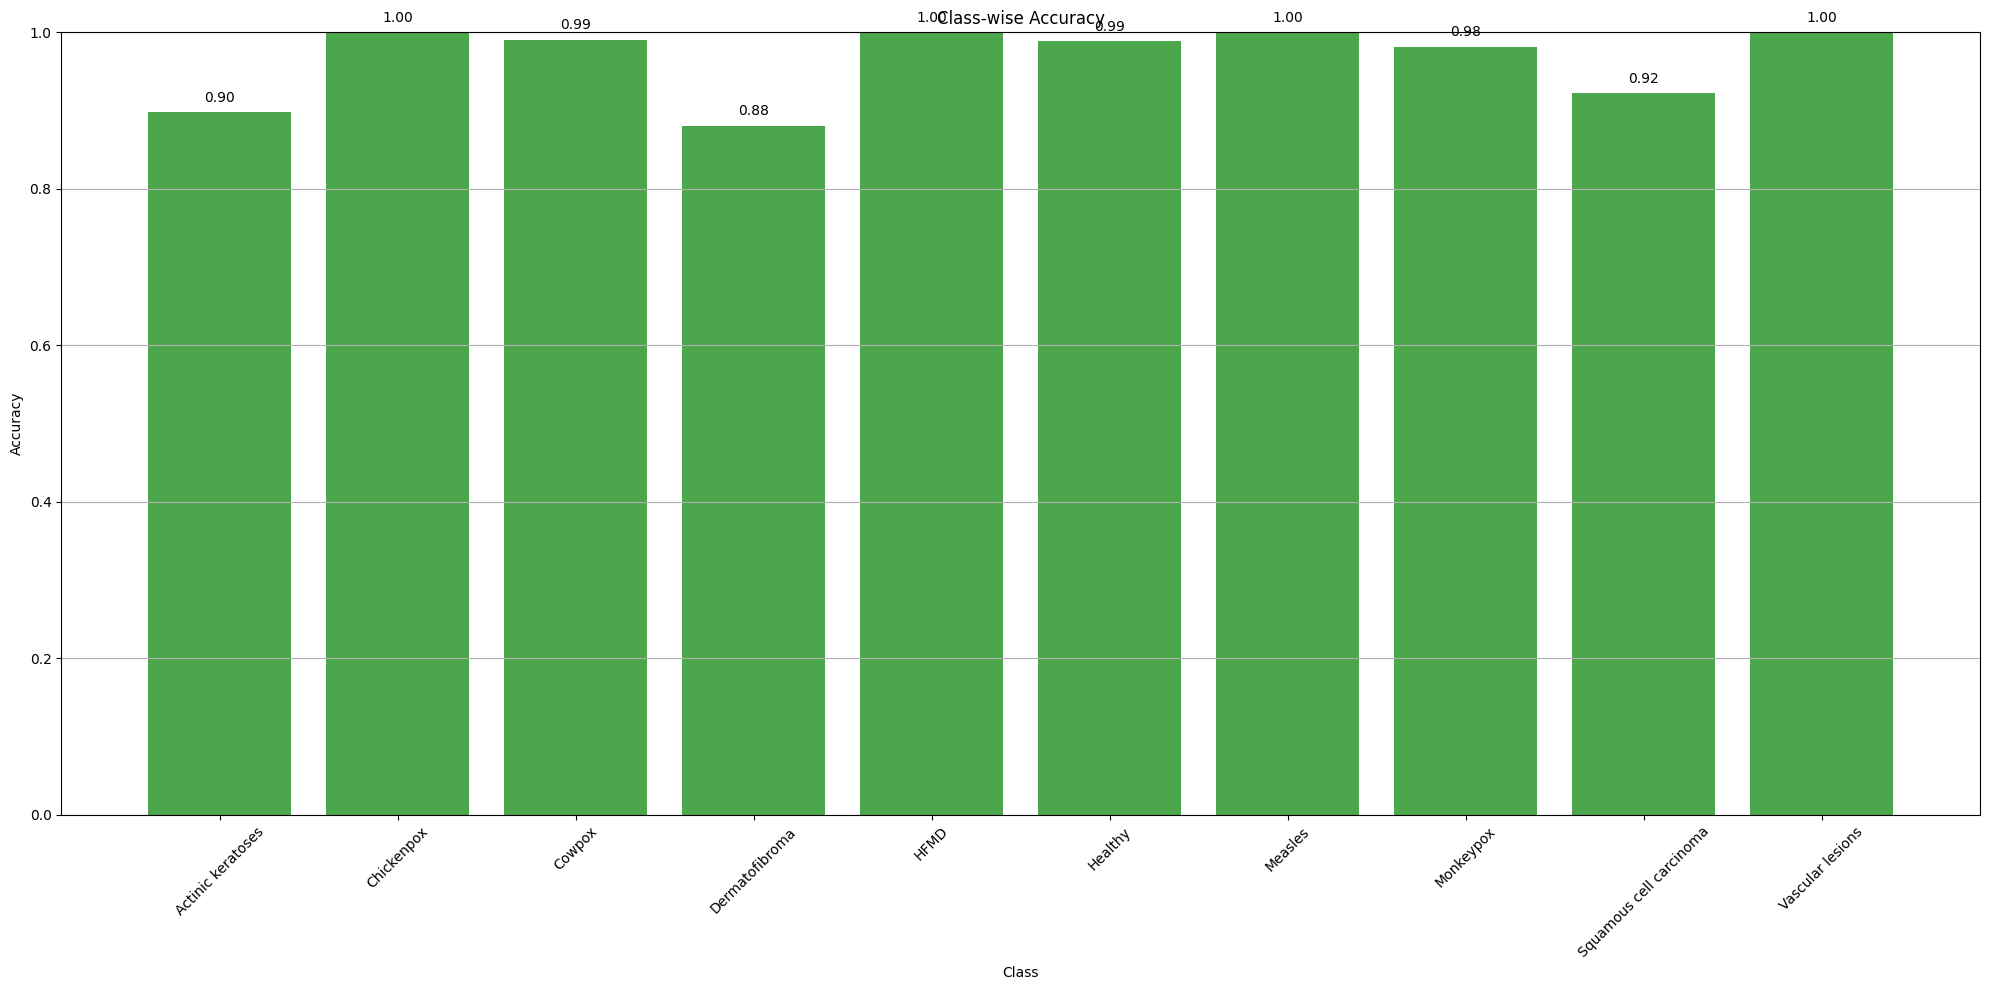

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Assuming class_names is available from earlier cells

# 1. Confusion Matrix and Histogram side by side (2 per row)
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Enhanced Confusion Matrix (left)
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=axes[0], xticks_rotation=45)
axes[0].set_title('Normalized Confusion Matrix')

# Histogram of Prediction Confidences (right)
top_probs = [np.max(p) for p in probs]
axes[1].hist(top_probs, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_xlabel('Prediction Confidence')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Confidences')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 2. Class-wise Accuracy as separate plot
plt.figure(figsize=(20, 10))
class_accuracies = []
for i in range(len(class_names)):
    mask = np.array(y_true) == i
    if np.sum(mask) > 0:
        acc = np.mean(np.array(y_pred)[mask] == i)
    else:
        acc = 0
    class_accuracies.append(acc)

plt.bar(range(len(class_names)), class_accuracies, color='green', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, v in enumerate(class_accuracies):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()